In [1]:
from pathlib import Path
import pickle

import librosa
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, mean_absolute_error, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

from extract_spectrogram import featureExtraction, compute_mfcc


# Import data and extract features

In [2]:
path = Path("data.csv")

if path.exists():
    data = pd.read_csv('data.csv')
else:
    data = featureExtraction()
    data.to_csv('data.csv')
    
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

In [3]:
data.shape, data.label.value_counts()

((999, 27),
 blues        100
 classical    100
 country      100
 disco        100
 jazz         100
 metal        100
 pop          100
 reggae       100
 rock         100
 hiphop        99
 Name: label, dtype: int64)

# Dense NN

In [17]:
# Label encoder
y_data = data.label
labels = np.unique(y_data)
nr_classes = len(labels)
y_data = LabelEncoder().fit_transform(y_data)

# Standard scaling
scaler = StandardScaler()
X_data = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)

In [18]:
# NN architecture
units = 512
nr_layers = 4

input_layer = Input((X_train.shape[1],))
x = Dense(units, activation='relu')(input_layer)
x = Dropout(.2)(x)
for _ in range(nr_layers):
    units /= 2
    x = Dense(units, activation='relu')(x)
    x = Dropout(.2)(x)

output_layer = Dense(nr_classes, activation='softmax')(x)

model = Model(input_layer, output_layer)
model.summary()

# Fitting
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 26)]              0         
                                                                 
 dense_13 (Dense)            (None, 512)               13824     
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                                 
 dropout_18 (Dropout)        (None, 128)               0   

In [6]:
# Model accuracy
pred = model.predict(X_test)
print('AUC = {}'.format(roc_auc_score(y_test, pred, multi_class="ovr")))
print(pd.Series(model.evaluate(X_test, y_test, batch_size=128), index=model.metrics_names))

AUC = 0.9972576075676172
2/2 [==============================] - 0s 10ms/step - loss: 0.2439 - accuracy: 0.9400
loss        0.243903
accuracy    0.940000
dtype: float64


Text(0, 0.5, 'Accuracy')

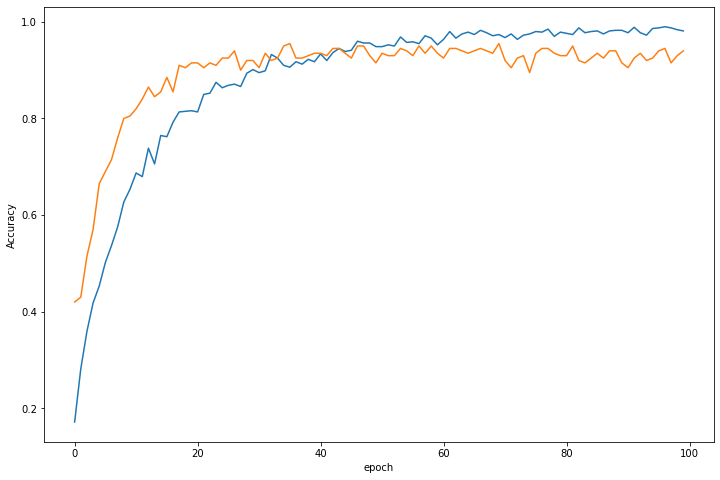

In [7]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('Accuracy')

Text(0.5, 1.0, 'Confusion matrix')

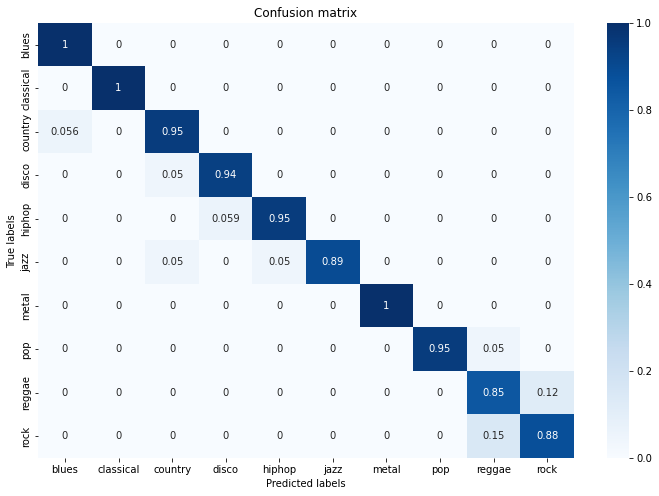

In [8]:
probabilities = model.predict(X_test)
predictedClasses = np.argmax(probabilities, axis=1)
confMat = pd.DataFrame(confusion_matrix(y_test, predictedClasses), index=labels, columns=labels)
confMat /= np.sum(confMat, axis=1)

plt.figure(figsize=(12,8))
sns.heatmap(confMat, cmap=plt.cm.Blues, annot=True)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title('Confusion matrix')

# CNN on the spectrogram images

In [9]:
folder = Path("data/genres_wav")

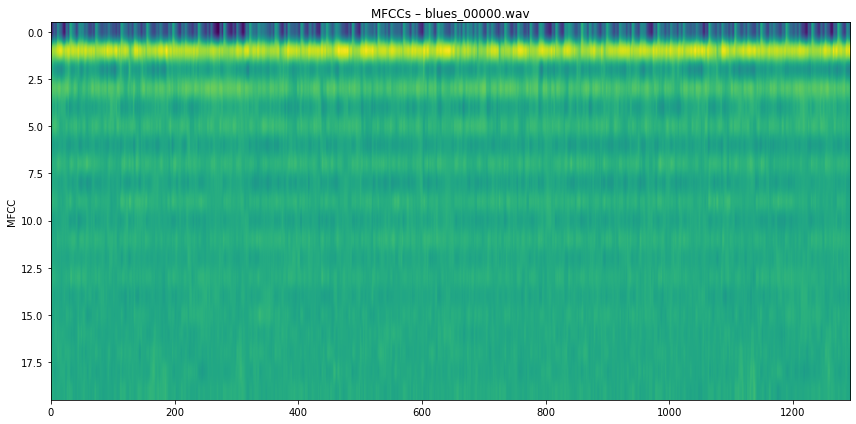

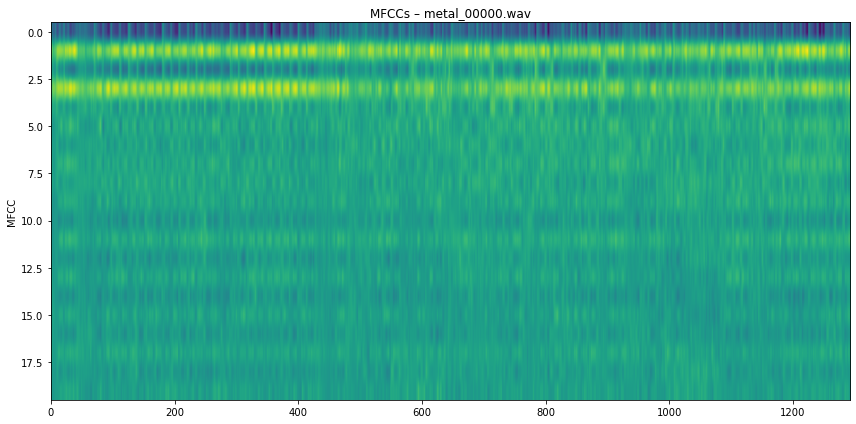

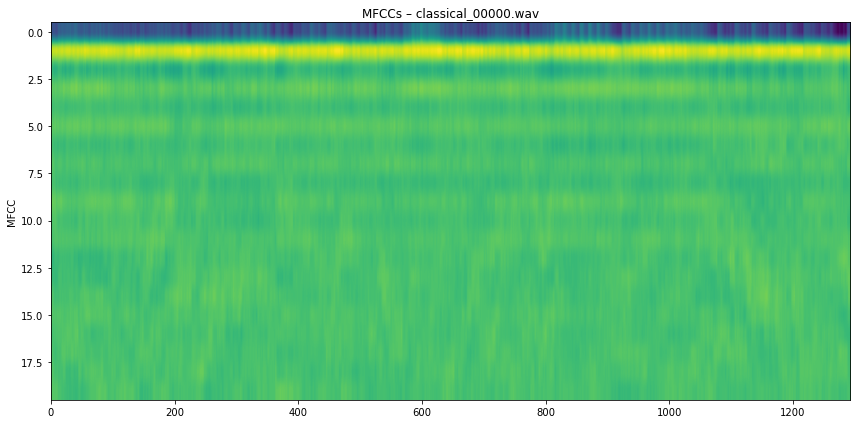

In [10]:
for path in [Path(folder, "blues_00000.wav"), Path(folder, "metal_00000.wav"), Path(folder, "classical_00000.wav")]:
    example_mfcc = compute_mfcc(path)
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.imshow(example_mfcc, aspect="auto")
    ax.set(title=f'MFCCs – {path.name}', ylabel='MFCC')
    plt.tight_layout()

In [11]:
dataset = np.array([compute_mfcc(path).T for path in folder.glob("*.wav")])
n, img_rows, img_cols = dataset.shape
dataset = dataset.reshape(n, img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
print('data shape: {}'.format(dataset.shape))
print('input shape: {}'.format(input_shape))

data shape: (999, 1292, 20, 1)
input shape: (1292, 20, 1)


In [12]:
targets = np.array([path.stem.split("_")[0] for path in  folder.glob("*.wav")])
labels = np.unique(targets)
nr_classes = len(labels)

In [13]:
# categorize the target
targets = LabelEncoder().fit_transform(targets)
#targets = to_categorical(targets, num_classes=nr_classes)

# train test split
X_train, X_test, y_train, y_test = train_test_split(dataset, targets, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [14]:
print(f"Train data: {X_train.shape}, {y_train.shape}")
print(f"Validation data: {X_val.shape}, {y_val.shape}")
print(f"Test data: {X_test.shape}, {y_test.shape}")

Train data: (799, 1292, 20, 1), (799,)
Validation data: (100, 1292, 20, 1), (100,)
Test data: (100, 1292, 20, 1), (100,)


In [15]:
# NN architecture
filters = 32
nr_layers = 4

input_layer = Input(input_shape)
x = Conv2D(filters=filters, kernel_size=(3, 3), activation="relu", padding="same")(input_layer)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Dropout(.2)(x)
for _ in range(nr_layers):
    filters *= 2
    x = Conv2D(filters=filters, kernel_size=(3, 3), activation="relu", padding="same")(x)
    #x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding="same")(x)
    x = Dropout(.2)(x)

x = Flatten()(x)
x = Dropout(.2)(x)
#x = Dense(64, activation="relu")(x)
#x = Dropout(.2)(x)
output_layer = Dense(nr_classes, activation='softmax')(x)

model = Model(input_layer, output_layer)
model.summary()

# Fitting
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1292, 20, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 1292, 20, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 646, 10, 32)      0         
 )                                                               
                                                                 
 dropout_5 (Dropout)         (None, 646, 10, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 646, 10, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 323, 5, 64)       0         
 2D)                                                       

KeyboardInterrupt: 

In [ ]:
print(pd.Series(model.evaluate(X_test, y_test), index=model.metrics_names))

4/4 [==============================] - 1s 159ms/step - loss: 1.3589 - accuracy: 0.5500
loss        1.358881
accuracy    0.550000
dtype: float64


Text(0, 0.5, 'Accuracy')

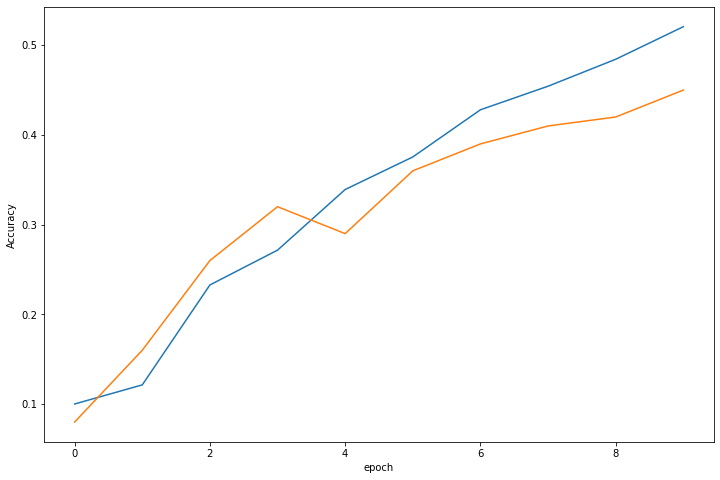

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('Accuracy')

Text(0.5, 1.0, 'Confusion matrix')

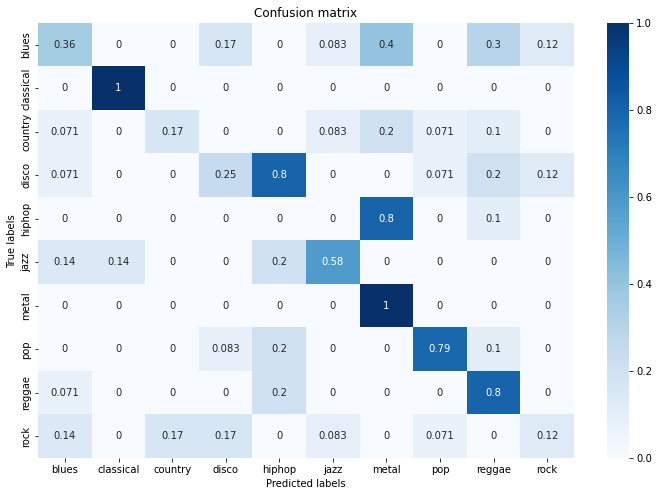

In [ ]:
probabilities = model.predict(X_test)
predictedClasses = np.argmax(probabilities, axis=1)
confMat = pd.DataFrame(confusion_matrix(y_test, predictedClasses), index=labels, columns=labels)
confMat /= np.sum(confMat, axis=1)

plt.figure(figsize=(12,8))
sns.heatmap(confMat, cmap=plt.cm.Blues, annot=True)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title('Confusion matrix')

In [ ]:
predictedClasses.shape

(100,)